## NYC Taxi Trip Duration (Ensemble Learning)

Now, that we have seen the Exploration and have a good understanding of data shape and structure.
* We also looked at firstly the basic models such as decision tree and linear regression.
* We created some features using the existing features in the dataset and also some features using external data

In this Notebook, we will cover the different ensemble methods and check if we can do better given the same set of features that we had created. Ensemble Techniques covered:

* Random Forest
* XGBoost (Gradient Boosting)
* Averaging Predictions
* Stacking

Finally, we will compare the results of these models and conclude with some other ideas for additional features that can be integrated to improve performance.

In the last module we built a decision tree to get better results than linear regression as follows:

<img src="tree.png" width=500 height=500>


## Data Dictionary
It is always a good idea to have the data dictionary handy.

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

Here dropoff_datetime and trip_duration are only available for the df set as that represents the target

### Load Libraries
We will load libraries required to build models and validation sets

In [3]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

### Load Data & Preprocessing

In [4]:
df = pd.read_csv('nyc_taxi_final.zip')

In [5]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [6]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']


### Feature Engineering

#### Eucledian Distance

In [7]:

#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5



#### Haversine Distance

In [8]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


#### Fastest route

In [9]:
fr1 = pd.read_csv('osrm/fastest_routes_train_part_1.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('osrm/fastest_routes_train_part_2.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


### Binning

In [10]:
### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

#### One Hot Encoding

In [11]:
df.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

In [12]:
df['vendor_id'] = df['vendor_id'] - 1

In [13]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

In [14]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

## Model Building

Now, before we go on to build the model, let us look at the dataset.

In [15]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,...,dist_sq,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,...,0.000159,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,...,0.001397,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,...,0.005287,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,...,0.000461,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,...,0.001872,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


### Cross validation

We will again use a similar function for cross validation as previously done to check performance of various ensemble models.

In [16]:
from math import sqrt
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index].values,df1.loc[test_index].values
        ytr,yvl = df_y[train_index].values,df_y[test_index].values

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

## Ensemble Models
Now that we have seen the performance of individual models, we have noted that decision tree has far better performance than other algorithms and it would be a good idea to try decision tree based ensemble models to check whether we improve on existing decision tree model or not.

### Random Forest

Random forests are an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Considering that we got a much more improved performance with decision trees. It is worthwhile to check tree based ensemble techniques.

In [20]:
rf_params = {'random_state': 0, 'n_estimators': 19, 'max_depth': 11, 'n_jobs': -1, "min_samples_split": 43}
rf_scores = cv_score(RandomForestRegressor(**rf_params))


1 of kfold 5
Valid RMSE: 0.41882

2 of kfold 5
Valid RMSE: 0.42053

3 of kfold 5
Valid RMSE: 0.41126

4 of kfold 5
Valid RMSE: 0.41594

5 of kfold 5
Valid RMSE: 0.41308


## XGBoost
Looking at the performance of Random forest, it would be a good idea to try XGBoost which is based on gradient boosting techniques and check performance. 

* First we will set the  hyperparameters for XGBoost and use cross validation to track and figure out the correct number of rounds so that it does not overfit.

* Later, we will fit the XGBoost Regressor using the number of rounds identified from the above step and check the cross validation scores

To find the approximate number of rounds for XGBoost, we will first create a validation set and check performance after each round.


In [21]:
#Splitting the data into df and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

In [22]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Finally! We're ready to use XGBoost. You'll notice that this part is actually quite short. But only in code. It can take quite a while to iterate through the different parameters and different values of these parameters to better the outcome of the model. There are several ways to do this and we will cover this in a later module.

In [23]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params['eval_metric'] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params['silent'] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 10000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=20)
print('Modeling RMSE %.5f' % xgb_model.best_score)

[0]	train-rmse:5.72169	valid-rmse:5.71896
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:2.09475	valid-rmse:2.09399
[40]	train-rmse:0.853706	valid-rmse:0.855293
[60]	train-rmse:0.499692	valid-rmse:0.50403
[80]	train-rmse:0.42656	valid-rmse:0.432475
[100]	train-rmse:0.410775	valid-rmse:0.417334
[120]	train-rmse:0.405011	valid-rmse:0.412099
[140]	train-rmse:0.400902	valid-rmse:0.408506
[160]	train-rmse:0.397748	valid-rmse:0.405907
[180]	train-rmse:0.395463	valid-rmse:0.404062
[200]	train-rmse:0.39326	valid-rmse:0.402266
[220]	train-rmse:0.391351	valid-rmse:0.40099
[240]	train-rmse:0.389774	valid-rmse:0.399857
[260]	train-rmse:0.388403	valid-rmse:0.398883
[280]	train-rmse:0.38714	valid-rmse:0.398047
[300]	train-rmse:0.385943	valid-rmse:0.39726
[320]	train-rmse:0.384958	valid-rmse:0.39668
[340]	train-rmse:0.383834	valid-rmse:0.396035
[360]	train-rmse:0.382939	valid-rmse:0.39556

Again, you can try tweaking parameters here but Be very careful, as boosting models have a high chance of overfitting i.e. training your model so well on the training set that it performs quite poorly on unseen data. Here I would suggest playing with `colsample_bytree` and `subsample` to control overfitting.


Now, we can investigate the importance of each feature, to understand what affects the trip duration the most significantly. Here's how XGBoost allows us to do it:

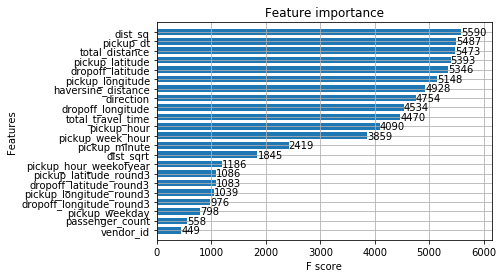

In [24]:
xgb.plot_importance(xgb_model, max_num_features=28, height=0.7)

So from top to bottom we see which features have the greatest effect on trip duration. It makes logical sense that the lattitude and longitude have high impact on predicting the trip duration. The further you travel, the longer it'll take. Interestingly, day of month is ranked higher here than day of week.

Remember that this is one way of looking at importance of features and it only signifies how important is a variable for XGBoost while fitting the training set.

In [25]:
xgb_params['num_round'] = xgb_model.best_iteration
xgb_model_final = xgb.XGBRegressor()
xgb_scores = cv_score(xgb_model_final)


1 of kfold 5
Valid RMSE: 0.42159

2 of kfold 5
Valid RMSE: 0.42307

3 of kfold 5
Valid RMSE: 0.41313

4 of kfold 5
Valid RMSE: 0.41718

5 of kfold 5
Valid RMSE: 0.41522


## Averaging

Bagging and boosting are 2 techniques. Now, we will cover 2 more advanced techniques.

First ensemble is an averaging model. Here, we simply take a weighted average of multiple models. The general rule here is to assign higher weight to the model which is giving better performance on the validation set.

I have defined a fresh function here to fit and calculate the scores from an averaged model comprising of XGBoost and Random Forest.

In [26]:
def cv_score_avg(ml_model_1, ml_model_2,w1 = 0.5, w2 = 0.5, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model_1
        ml_model_1.fit(xtr, ytr)
        pred_val_1 = ml_model_1.predict(xvl)
        
        model = ml_model_2
        ml_model_2.fit(xtr, ytr)
        pred_val_2 = ml_model_2.predict(xvl)
        
        final_pred=(pred_val_1*w1 + pred_val_2*w2)

        rmse_score = sqrt(mean_squared_error(yvl, final_pred))
        
        sufix = ""
        msg = ""
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

In [27]:
avg_scores = cv_score_avg(xgb_model_final, RandomForestRegressor(**rf_params), w1 = 0.4, w2 = 0.6)


1 of kfold 5
Valid RMSE: 0.41540

2 of kfold 5
Valid RMSE: 0.41711

3 of kfold 5
Valid RMSE: 0.40736

4 of kfold 5
Valid RMSE: 0.41207

5 of kfold 5
Valid RMSE: 0.40933


## Stacking
Second ensemble is a stacked model. Mlxtend library includes code for this that does the out-of-fold predictions and later fitting the second-level model. Let's see how this works now.

In [28]:
# Model Definitions for feeding into Stacking
xgb_model = xgb.XGBRegressor(**xgb_params)
rf_model = RandomForestRegressor(**rf_params)
tree_model = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)

In [29]:
# Importing Stacking regressor from mlxtend
from mlxtend.regressor import StackingCVRegressor

stacked_model = StackingCVRegressor(
    regressors=[xgb_model, rf_model],
    meta_regressor=Ridge()
)

In [30]:
stacking_scores = cv_score(stacked_model)


1 of kfold 5
Valid RMSE: 0.40269

2 of kfold 5
Valid RMSE: 0.40388

3 of kfold 5
Valid RMSE: 0.39484

4 of kfold 5
Valid RMSE: 0.39943

5 of kfold 5
Valid RMSE: 0.39583


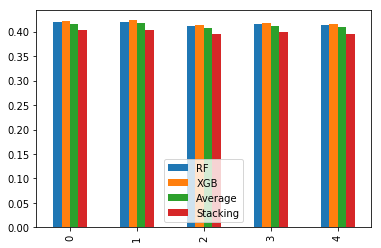

In [31]:
results_df = pd.DataFrame({'RF':rf_scores, 'XGB': xgb_scores, 'Average': avg_scores, 'Stacking':stacking_scores})
results_df.plot(y=["RF", "XGB","Average","Stacking"], kind="bar")

Stacking does give us the best performance out of all ensemble techniques as is clear from the plot above. However, averaging did not perform much better and this is due to the difference in performance of RF and XGBoost. Tweaking some hyperparameters to make RF better and ultimately create new weighted ensemble can give better perfomance. 

### What next?

When it comes to machine learning and model building. There are tons of experiments and iterations that can be done. Here, we have tried to cover some of the best practices for approaching a data science and predictive analytics problem. Going forward there are many things we can go ahead and try to further improve the models:

* Add weather features
* Add traffic density features
* Add Public Holidays
* Try more boosting based techniques